training data image shape (50000, 32, 32, 3)
training data label shape (50000, 1)
testing data image shape (10000, 32, 32, 3)
testing data label shape (10000, 1)


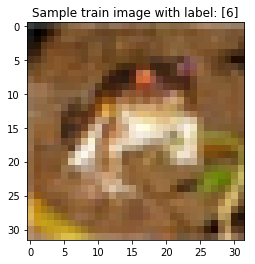

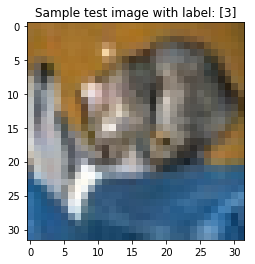

In [2]:
# Part 1: Download the dataset (cifar10 for experiment purpose)
from keras.datasets import cifar10
# Load the dataset to ndarray
(x_train, y_train), _ = cifar10.load_data()
# Print the shape of each test and train dataset
print('training data image shape {}'.format(x_train.shape))
print('training data label shape {}'.format(y_train.shape))
print('testing data image shape {}'.format(x_test.shape))
print('testing data label shape {}'.format(y_test.shape))
# View one image in the training data and one image in the testing data
import matplotlib.pyplot as plt
# Display one training image
plt.imshow(x_train[0])
plt.title('Sample train image with label: {}'.format(y_train[0]))
plt.show()
# Display one testing image
plt.imshow(x_test[0])
plt.title('Sample test image with label: {}'.format(y_test[0]))
plt.show()

In [26]:
# Part 2: Split the dataset
import numpy as np
from skimage.transform import resize
# Let's split to data into training (90%), validation (10%)
train_data = np.split(x_train, [int(0.9*x_train.shape[0]), x_train.shape[0]])
train_images_raw = train_data[0]
validation_images_raw = train_data[1]

label_data = np.split(y_train, [int(0.9*y_train.shape[0]), y_train.shape[0]])
train_labels = np.squeeze(label_data[0])
validation_labels = np.squeeze(label_data[1])

def getImages(images):
    images = images/255.0 # Normalize the image data
    # Create the image holder array
    image_arr = np.zeros((images.shape[0], 3, 32, 32))
    # Iterate through the image data
    for i, im in enumerate(images):
        # We need a fixed size input, our images have different sizes, let's pick 32x32.
        # Resize image below
        im = resize(im, output_shape=(32, 32))
        # Gluon/mxnet expects images in this format (channel, row, column)
        # This is the opposite of (row, column, channel), let's fix it
        im = np.moveaxis(im, -1, 0)
        # Assign the value in the image array
        image_arr[i] = im
    return image_arr

train_images = getImages(train_images_raw)
validation_images = getImages(validation_images_raw)

print('train_images has shape: {}'.format(train_images.shape))
print('validation_images has shape: {}'.format(validation_images.shape))

train_images has shape: (45000, 3, 32, 32)
validation_images has shape: (5000, 3, 32, 32)


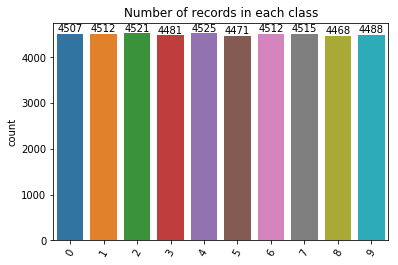

In [28]:
# Part 3: Plot the class distribution
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure()
ax = sb.countplot(x=train_labels, y=None)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(int(y), (x.mean(), y), ha='center', va='bottom') 
plt.xticks(rotation=60)
plt.title('Number of records in each class')
plt.show()

In [29]:
# Part 4: Define confusion matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm)
    plt.title('Validation Confusion Matrix')
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [31]:
# Part 5: Check if you machine has GPU or not
import mxnet as mx
mx.context.num_gpus()

0

Epoch 0, training loss: 2.303462267, validation loss: 2.302973747, training accuracy: 0.105155556, validation accuracy: 0.098600000


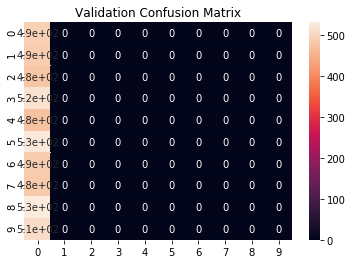

In [35]:
# Part 6: Training and validation
import mxnet as mx
from mxnet import gluon, autograd, ndarray
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from mxnet.gluon.model_zoo import vision
import mxnet.ndarray as nd
from sklearn.metrics import accuracy_score

# Set this to CPU or GPU depending on the result in the first step
ctx = mx.cpu()
# ctx = mx.gpu()

# Paramaters for the model 
batch_size = 32
epochs = 1
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.3 # weight decay for the trainer
conf_matrix_freq = 1 # Plot confusion matrix after each 1 epoch
# overfit_indicator parameter keeps track of the highest validation accuracy from the previous epochs. 
# If it doesn't improve in the next 5 epochs, it stops the training
# This helps us prevent overfitting our model
overfit_indicator = 5
# Create the network. We have 5 classes
num_outputs = 10

# Load the pre-train models from the model zoo.
pre_trained_net = vision.mobilenet1_0(pretrained=True, ctx=ctx)
# A list of other models can be found in here
# https://mxnet.apache.org/api/python/docs/api/gluon/model_zoo/index.html
net = vision.mobilenet1_0(classes=num_outputs, ctx=ctx)
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
net.features = pre_trained_net.features

# Define loss and trainer.
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(
    net.collect_params(), 
    'nag', 
    {'learning_rate': learning_rate, 'momentum': momentum, 'wd': weight_decay})

highest_validation_acc = 0
overfit_counter = 0

for epoch in range(epochs):
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    cumulative_train_loss = 0
    train_predictions = []
    for i in range(0, train_images.shape[0], batch_size):
        data = nd.array(train_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(train_labels[i:i + batch_size]).as_in_context(ctx)
        with autograd.record():
            output = net(data)
            train_predictions = train_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
            loss = softmax_cross_etropy_loss(output, label)
            cumulative_train_loss = cumulative_train_loss + nd.sum(loss)
        loss.backward()
        trainer.step(data.shape[0])
    
    # Calculating the Softmax Cross Entopy Loss for training
    train_loss = cumulative_train_loss/len(train_images)

    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    cumulative_valid_loss = 0
    val_predictions = []
    for i in range(0, validation_images.shape[0], batch_size):
        data = nd.array(validation_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
        label = nd.array(validation_labels[i:i + batch_size]).as_in_context(ctx)
        output = net(data)
        val_predictions = val_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
        val_loss = softmax_cross_etropy_loss(output, label)
        cumulative_valid_loss = cumulative_valid_loss + nd.sum(val_loss)
    valid_loss = cumulative_valid_loss/len(validation_images)

    # Calculate training and validation accuracies
    # accuracy = (TP+TN) / (TP+FP+TN+FN)
    train_accuracy = accuracy_score(train_labels.tolist(), train_predictions)
    validation_accuracy = accuracy_score(validation_labels.tolist(), val_predictions)
    
    # Let's check the highest accuracy and apply the patiance logic here.
    if validation_accuracy > highest_validation_acc:
        highest_validation_acc = validation_accuracy
        overfit_counter = 0
    else:
        overfit_counter = overfit_counter + 1
        
    # Print the summary and plot the confusion matrix after each epoch
    print("Epoch {}, training loss: {:.9f}, validation loss: {:.9f}, training accuracy: {:.9f}, validation accuracy: {:.9f}".format(
        epoch, train_loss.asnumpy()[0], valid_loss.asnumpy()[0], train_accuracy, validation_accuracy))

    if epoch % conf_matrix_freq==0: plot_confusion_matrix(validation_labels.tolist(), val_predictions)
    
    # If we pass the patiance threshold, break the loop (stop the training)
    if overfit_counter > overfit_indicator:
        break

In [39]:
# Part 7: Testing
_, (x_test, y_test) = cifar10.load_data()

test_images = getImages(x_test)
test_predictions = []
for i in range(0, test_images.shape[0], batch_size):
    data = nd.array(test_images[i:i + batch_size].astype('float32')).as_in_context(ctx)
    output = net(data)
    test_predictions = test_predictions + np.argmax(output.asnumpy(), axis=1).tolist()
# Print the accuracy for the test data
test_accuracy = accuracy_score(np.squeeze(y_test), test_predictions)
print('Test data accuracy is {}'.format(test_accuracy))

Test data accuracy is 0.1
